https://www.kaggle.com/competitions/interpretation-of-animal-actions-in-the-video-stre/overview

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
import seaborn as sns

1. clean_data(df: pd.DataFrame):

Эта функция принимает на вход DataFrame и выполняет следующие операции:

Создает копию входного DataFrame, чтобы оригинальные данные не были повреждены.
Переводит данные о типе животного из формата 'one-hot encoded' в числовой, используя словарь animal_mapping.
Удаляет некоторые столбцы из DataFrame. Она удаляет столбцы, которые относятся к типу животного, столбец 'id', все столбцы, имена которых оканчиваются на '_v', и некоторые другие столбцы, связанные с координатами частей тела животных.

2. load_and_clean_data(file_path):

Эта функция загружает данные из CSV-файла, сохраняет идентификаторы из столбца 'id' в отдельной переменной df_ids и затем обрабатывает данные, используя функцию clean_data.

3. load_and_transform_labels(file_path):

Эта функция загружает метки из CSV-файла и выполняет следующие операции:

Переводит данные о типе действия из формата 'one-hot encoded' в числовой, используя словарь action_mapping.
Удаляет столбцы, которые относятся к типу действия, и столбец 'id'.

In [ ]:
def clean_data(df: pd.DataFrame):
    df_cleaned = df.copy()

    animal_mapping = {"cow": 0, "cat": 1, "dog": 2, "horse": 3, "sheep": 4}
    df_cleaned['animal'] = df_cleaned[['cat', 'cow', 'dog', 'horse', 'sheep']].idxmax(axis=1).replace(animal_mapping)

    columns_to_drop = ['cat', 'cow', 'dog', 'horse', 'sheep', 'id']
    columns_to_drop += list(df_cleaned.filter(regex='_v'))
    columns_to_drop += ["R_eye_x", "L_F_elbow_x", "L_B_elbow_x", "L_F_knee_x", "L_B_paw_x"]
    df_cleaned.drop(columns=columns_to_drop, inplace=True)

    return df_cleaned

def load_and_clean_data(file_path):
    df = pd.read_csv(file_path)
    df_ids = df['id']
    df_cleaned = clean_data(df)
    return df_cleaned, df_ids

def load_and_transform_labels(file_path):
    df = pd.read_csv(file_path)

    action_mapping = {"nothing": 0, "stand": 1, "sit": 2, "lie": 3, "go": 4, "run": 5}
    df['action_type'] = df[['nothing', 'stand', 'sit', 'lie', 'go', 'run']].idxmax(axis=1).replace(action_mapping)
    df.drop(columns=['nothing', 'stand', 'sit', 'lie', 'go', 'run', 'id'], inplace=True)

    return df

In [ ]:
x, x_ids = load_and_clean_data('x_train.csv')
x_test, x_test_ids = load_and_clean_data('x_test.csv')

In [ ]:
x.head()

,bounds_x,bounds_y,bounds_width,bounds_height,L_eye_x,L_eye_y,R_eye_y,L_ear_x,L_ear_y,R_ear_x,...,R_B_knee_x,R_B_knee_y,L_F_paw_x,L_F_paw_y,R_F_paw_x,R_F_paw_y,L_B_paw_y,R_B_paw_x,R_B_paw_y,animal
0,37,16,240,170,0,0,145,0,0,262,...,49,127,208,167,161,168,173,55,177,0
1,43,8,208,236,0,0,43,206,18,212,...,113,185,167,213,193,209,232,115,233,3
2,65,0,234,222,180,67,63,222,56,109,...,0,0,0,0,0,0,0,0,0,2
3,15,8,272,178,0,0,25,0,0,231,...,40,139,169,171,190,172,176,35,178,0
4,2,1,148,146,135,68,70,142,35,91,...,24,107,129,130,68,131,128,0,0,1


In [ ]:
y = load_and_transform_labels('y_train.csv')
y.head()

,action_type
0,4
1,4
2,0
3,1
4,3


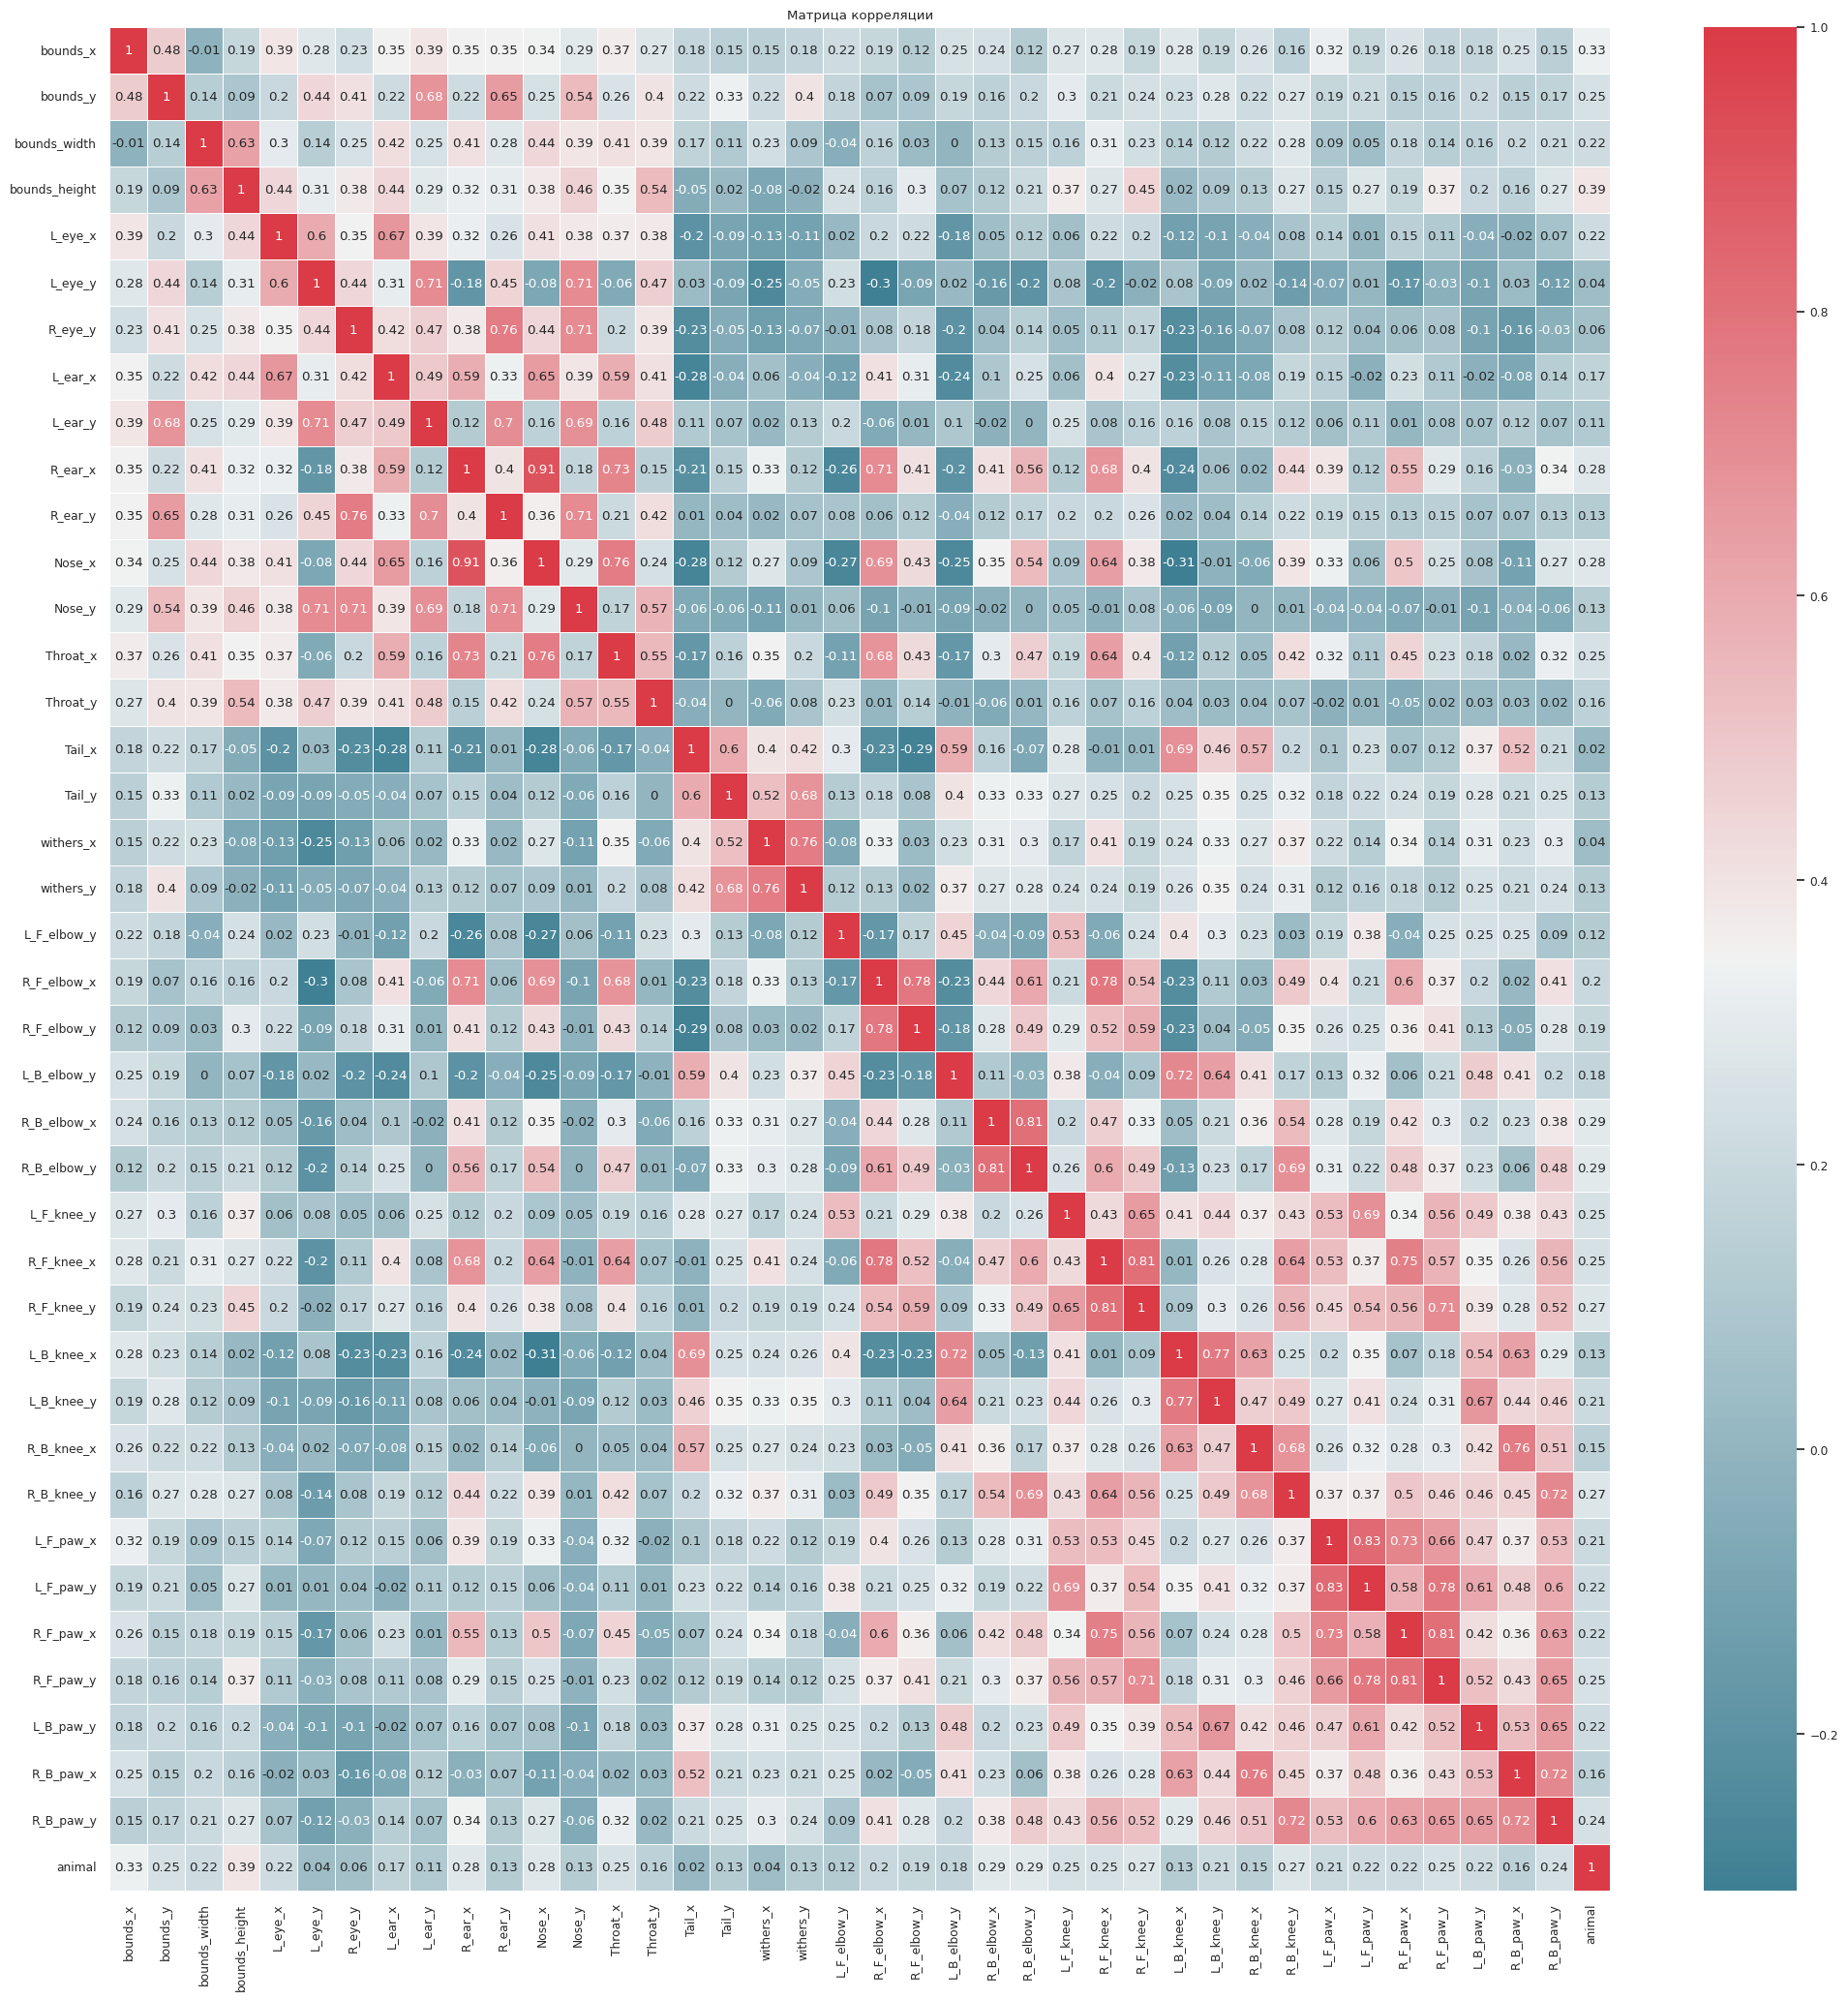

In [ ]:
plt.figure(figsize = (25,25))

sns.set(font_scale=0.8)

corr_matrix = x.corr()
corr_matrix = np.round(corr_matrix, 2)

custom_cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap=custom_cmap)

plt.title('Матрица корреляции')
plt.show()

# Масштабирование данных

Сначала создается экземпляр класса StandardScaler, который будет использоваться для масштабирования данных. Масштабирование полезно, поскольку оно приводит все признаки к одному и тому же масштабу, что помогает алгоритмам машинного обучения работать эффективнее.

Затем метод fit_transform применяется к обучающим данным (x), чтобы посчитать среднее и стандартное отклонение каждого признака и затем нормализовать данные, используя эти параметры.

Метод transform применяется к тестовым данным (x_test), чтобы нормализовать их, используя те же параметры, что и для обучающих данных.

In [ ]:
scaler = StandardScaler()
x = scaler.fit_transform(x)
x_test = scaler.transform(x_test)

# Обучение

Данные разделяются на обучающий и валидационный наборы с помощью функции train_test_split. Размер валидационного набора составляет 20% от общего объема данных, а генератор случайных чисел инициализируется конкретным значением (random_state=65), чтобы обеспечить воспроизводимость результатов.

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=65)

Затем создается модель градиентного бустинга, используя GradientBoostingClassifier с указанными гиперпараметрами.

Наконец, модель обучается на обучающем наборе данных с помощью метода fit.

Градиентный бустинг — это метод машинного обучения, который использует ансамбль слабых моделей, обычно деревьев решений, для создания одной сильной предсказательной модели.

Вот как это работает в простейших терминах:

Сначала алгоритм обучает слабую модель на ваших данных. Эта модель, вероятно, не будет очень хорошей, но она дает стартовую точку.

Затем алгоритм посмотрит, где модель ошибается, и обучит следующую модель так, чтобы она исправляла эти ошибки.

Процесс повторяется, с каждым шагом модель становится все лучше и лучше в предсказании данных.

В конце у нас есть много слабых моделей, каждая из которых исправляет ошибки предыдущей. Когда мы комбинируем все эти модели вместе, мы получаем одну сильную модель, которая хорошо предсказывает наши данные.

GradientBoostingClassifier в Python представляет собой реализацию этого алгоритма для задач классификации.

In [ ]:
model = GradientBoostingClassifier(n_estimators=500, max_depth=10, min_samples_split=2, random_state=48)
model.fit(x_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingClassifier(max_depth=10, n_estimators=500, random_state=48)

In [ ]:
y_pred = model.predict(x_val)

# Оцениваем модель
print(f"Model f1_score: {f1_score(y_val, y_pred, average='micro')}")

# Предсказываем на тестовом наборе
y_pred_test = model.predict(x_test)

submission = pd.DataFrame({"id": x_test_ids, "label": y_pred_test})

submission.to_csv("submission.csv", index=False)

Model f1_score: 0.6102941176470589
